# Red wine quality classifier using a Neural network

Data provided by the UCI: https://archive.ics.uci.edu/ml/datasets/wine+quality

### Imports

Libraries import


In [662]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.calibration import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

## Supress TensorFlow warnings

In [663]:
# https://weepingfish.github.io/2020/07/22/0722-suppress-tensorflow-warnings/

def import_tensorflow():
    # Filter tensorflow version warnings
    import os
    # https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
    import warnings
    # https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    import tensorflow as tf
    tf.get_logger().setLevel('INFO')
    tf.autograph.set_verbosity(0)
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    return tf

## Import the Data

In [664]:
tf = import_tensorflow() 

In [665]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [666]:
df.shape

(1599, 12)

In [667]:
dataset = df.values

In [668]:
dataset

array([[ 7.4  ,  0.7  ,  0.   , ...,  0.56 ,  9.4  ,  5.   ],
       [ 7.8  ,  0.88 ,  0.   , ...,  0.68 ,  9.8  ,  5.   ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  0.65 ,  9.8  ,  5.   ],
       ...,
       [ 6.3  ,  0.51 ,  0.13 , ...,  0.75 , 11.   ,  6.   ],
       [ 5.9  ,  0.645,  0.12 , ...,  0.71 , 10.2  ,  5.   ],
       [ 6.   ,  0.31 ,  0.47 , ...,  0.66 , 11.   ,  6.   ]])

## Exploratory Data Analysis


Correlation matrix

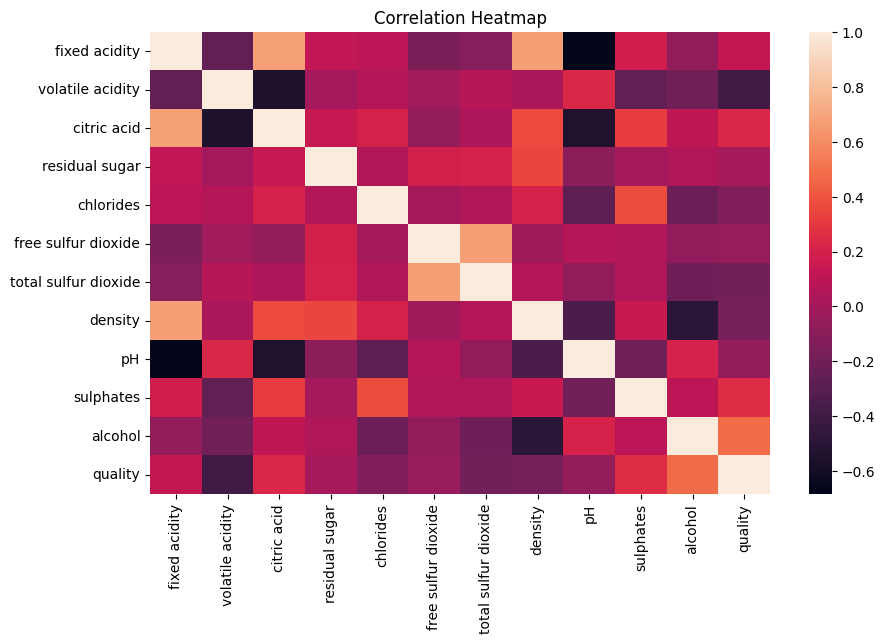

In [669]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot a heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix)
plt.title("Correlation Heatmap")
plt.show()

Scatter plot: Fixed acidity - Density

<Axes: xlabel='fixed acidity', ylabel='density'>

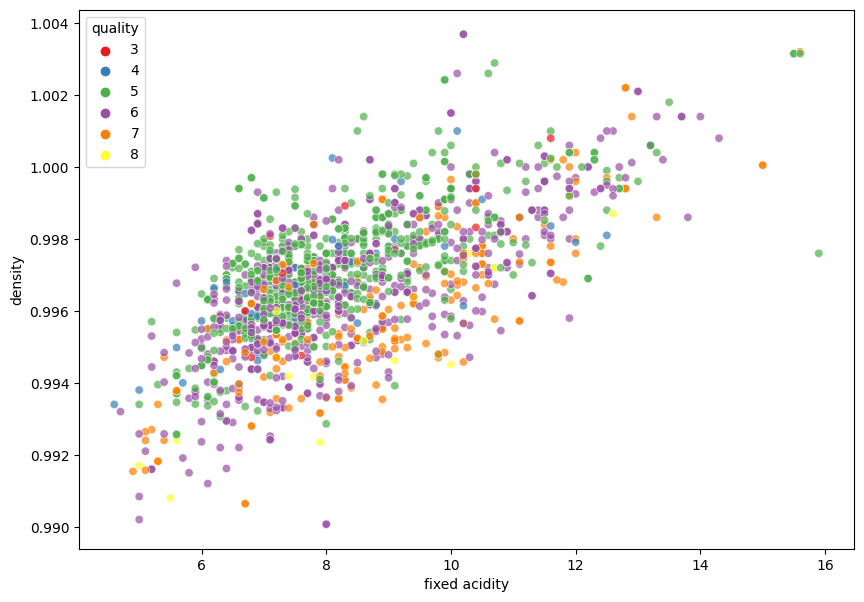

In [670]:
plt.figure(figsize = (10 , 7))
sns.scatterplot(x = "fixed acidity", y = "density", hue = "quality",data = df, alpha = 0.7, palette = "Set1")

Explore the features using histograms

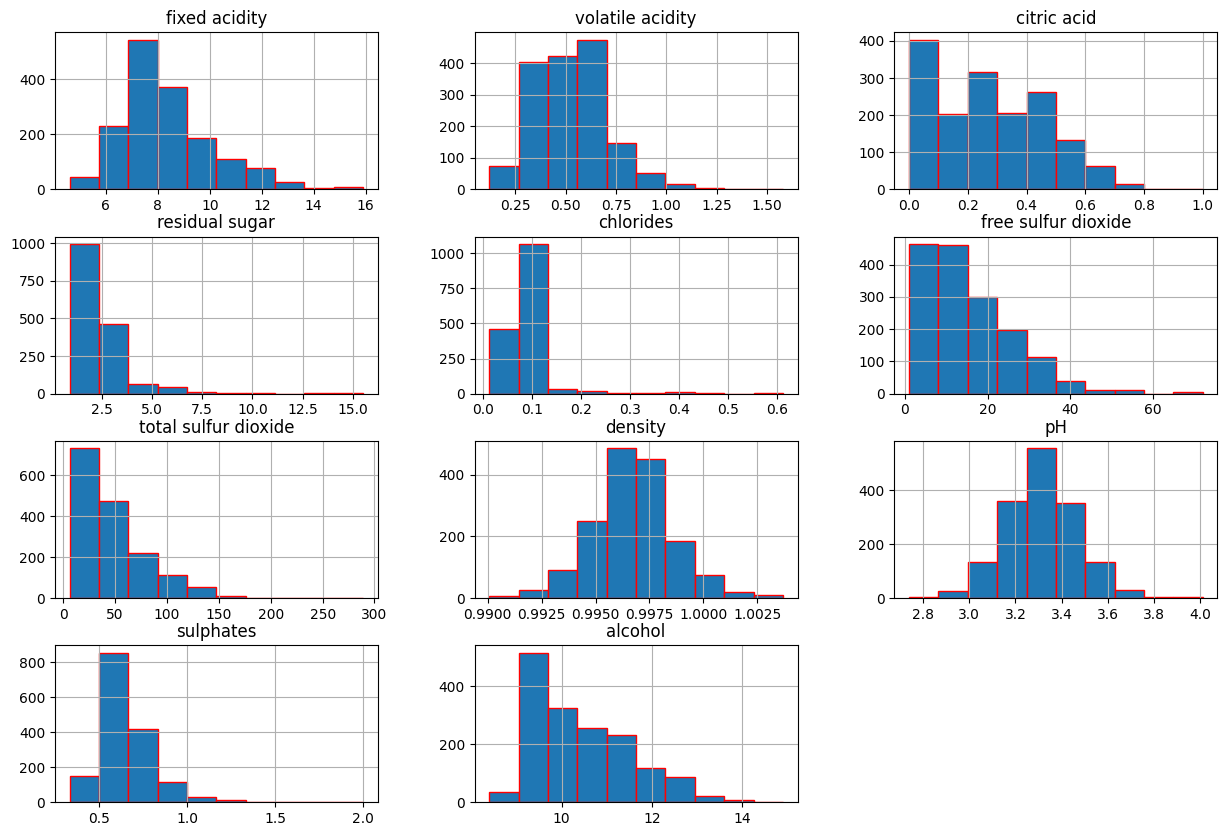

In [671]:
input_variables = [
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol'
]

# Create histograms for each input variable
df.hist(input_variables , edgecolor = 'red' ,figsize=(15,10))
# display histogram
plt.show()

In [672]:
# replace zero values for citric acid with 1% of mean
df['citric acid']=df['citric acid'].replace(0,df['citric acid'].mean()*0.01)

In [673]:
#scale data using standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

In [674]:
#Seperating the dataset as response variable and feature variabes
X = df.drop ('quality',axis =1 )
X.columns = X.columns.str.replace(' ', '_') #needed because tensor dictionary can not have spaces

In [675]:
# Define feature columns
feature_columns = []
for feature_name in X.columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

Encoding the quality

In [676]:
X.shape

(1599, 11)

In [677]:
le = LabelEncoder()
y = le.fit_transform(df.iloc[: , -1])
y = pd.DataFrame(y.reshape(len(y),1))

In [678]:
y.shape

(1599, 1)

In [679]:
y.value_counts()

2    681
3    638
4    199
1     53
5     18
0     10
Name: count, dtype: int64

### Spliting data


### Transforming quality to categorical data

In [680]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [681]:
# python dictionary of X_train for tensor
X_train_dict = X_train.to_dict(orient='list')
y_train_array = np.array(y_train)
X_test_dict = X_test.to_dict(orient='list')
y_test_array = np.array(y_test)

In [682]:
# One-hot encode y_train and y_test
y_train_cat = tf.keras.utils.to_categorical(y_train, 6)
y_test_cat = tf.keras.utils.to_categorical(y_test, 6)

## Neural Network using TF Estimator DNN Classifier

In [683]:
def input_fn(features, labels, training=True, batch_size=128):
  # Convert the inputs to a Dataset.
  dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
  # Shuffle and repeat if you are in training mode.
  if training:
      dataset = dataset.shuffle(1000).repeat()
  return dataset.batch(batch_size)

In [684]:
from tensorflow.keras.layers import DenseFeatures
from tensorflow.keras import layers
from tensorflow_estimator.python.estimator.canned.dnn import DNNClassifier

classifier = DNNClassifier(
    hidden_units=[128,64,32],
    feature_columns=feature_columns,
    n_classes=10,
    optimizer='Adam')

In [685]:
classifier.train(input_fn=lambda: (X_train_dict, y_train), steps=200)

In [686]:
#evaluate the test data based on the training results
eval_result = classifier.evaluate(input_fn=lambda: (X_test_dict, y_test),steps=200)

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.566



#### In conclusion, the deep neural network model implemented using TensorFlow's `DNNClassifier` achieved an accuracy of **56.9%** on the test set. While this indicates that the model is able to make correct predictions more than half of the time, there is significant room for improvement. Strategies for enhancing the model's performance could include feature engineering, hyperparameter tuning, gathering more data, or experimenting with different types of models. As with all machine learning tasks, achieving the optimal model performance will likely require a process of experimentation and refinement.

## Neural Network using TF.Keras

In [687]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

ann = tf.keras.models.Sequential()

ann.add(tf.keras.layers.Input(shape = 11,))
ann.add(tf.keras.layers.Dense(units = 256 , activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
ann.add(tf.keras.layers.Dropout(0.5))
ann.add(tf.keras.layers.Dense(units = 256 , activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
ann.add(tf.keras.layers.Dropout(0.5))
ann.add(tf.keras.layers.Dense(units = 6, activation = "sigmoid"))
ann.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 256)               3072      
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 70406 (275.02 KB)
Trainable params: 70406 (275.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [688]:
ann.compile(optimizer = 'adam' , loss='mse' ,metrics= ['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [689]:
hist_1 = ann.fit(
    X_train, y_train_cat,
    batch_size = 128,
    epochs = 250,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stopping]
)

Epoch 1/250
10/10 [==============================] - 1s 24ms/step - loss: 2.7386 - accuracy: 0.2768 - val_loss: 2.3785 - val_accuracy: 0.4125
Epoch 2/250
10/10 [==============================] - 0s 8ms/step - loss: 2.1609 - accuracy: 0.4027 - val_loss: 1.8898 - val_accuracy: 0.4000
Epoch 3/250
10/10 [==============================] - 0s 9ms/step - loss: 1.7030 - accuracy: 0.4175 - val_loss: 1.4770 - val_accuracy: 0.4750
Epoch 4/250
10/10 [==============================] - 0s 8ms/step - loss: 1.3411 - accuracy: 0.4175 - val_loss: 1.1516 - val_accuracy: 0.4688
Epoch 5/250
10/10 [==============================] - 0s 8ms/step - loss: 1.0521 - accuracy: 0.4355 - val_loss: 0.9092 - val_accuracy: 0.4750
Epoch 6/250
10/10 [==============================] - 0s 8ms/step - loss: 0.8283 - accuracy: 0.4339 - val_loss: 0.7166 - val_accuracy: 0.4844
Epoch 7/250
10/10 [==============================] - 0s 8ms/step - loss: 0.6581 - accuracy: 0.4504 - val_loss: 0.5758 - val_accuracy: 0.4812
Epoch 8/250


In [690]:
accuracy = ann.evaluate(X_test, y_test_cat)
print("Test Accuracy:", accuracy)

10/10 [==============================] - 0s 2ms/step - loss: 0.1056 - accuracy: 0.4750
Test Accuracy: [0.1055590882897377, 0.4749999940395355]


Model Architecture: The model is a fully connected neural network with two hidden layers, each with 256 units. The use of ReLU activation functions and L2 regularization in these layers suggests an attempt to manage the complexity of the model and prevent overfitting. The output layer uses a sigmoid activation function, indicating that this is a binary classification problem.

Training Process: The model was trained using the Adam optimizer and mean squared error loss function. Early stopping was employed as a form of regularization to prevent overfitting. The batch size was set to 128, and the model was trained for up to 250 epochs, although early stopping may have halted training before reaching this maximum number of epochs.

Model Performance: The graph shows that both the training and validation accuracy of the model increased sharply in the initial epochs, then fluctuated around the 0.45 - 0.50 range. This suggests that the model was learning effectively in the early stages of training, but may have started to overfit the training data in the later stages, as indicated by the plateau in validation accuracy. 

#### loss and validation loss graph

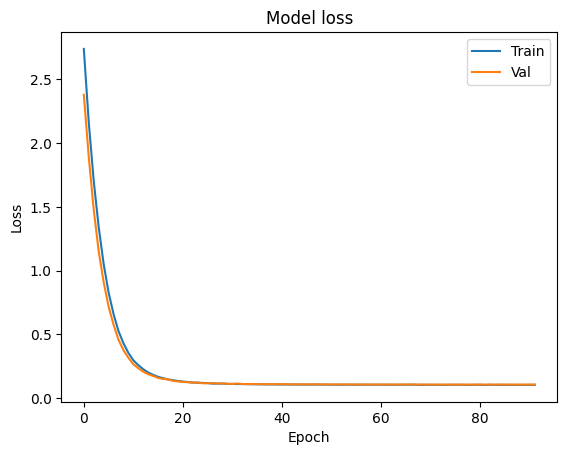

In [691]:
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

From the graph, we can observe that:

- The training loss shows a sharp decline before plateauing around epoch 20.
- In contrast, the validation loss remains relatively flat across all epochs, indicating minimal change in validation loss.


#### accuracy and validation accuracy

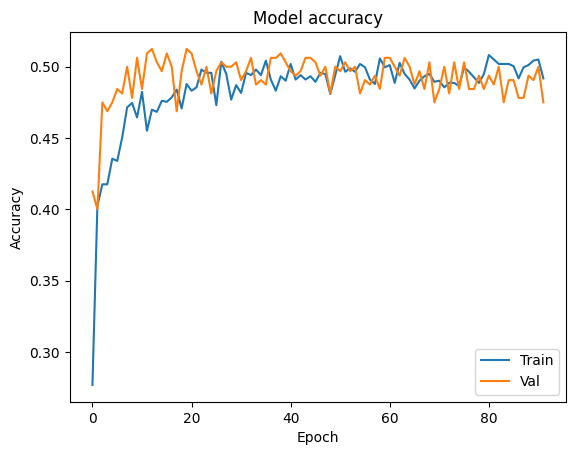

In [692]:
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

## Conclussion 

The model seems to be overfitting the training data, as indicated by the high training accuracy and low training loss, but constant validation loss and lower validation accuracy.

Given the fluctuation and plateau in validation accuracy, model can be improved by tuning hyperparameters like learning rate, batch size, number of epochs, adjusting the model architecture like number of layers, number of units per layer, types of activation functions, or using different types of regularization like dropout rate, type of weight regularization.